In [1]:
#MNIST(machine learning 계의 hello world!)
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame=False) #as_frame은 pandas dataframe으로 받을건지 결정

C:\Users\BIG3-09\AppData\Roaming\Python\Python311\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
X,y = mnist.data,mnist.target

In [3]:
print(X.shape,y.shape)

(70000, 784) (70000,)


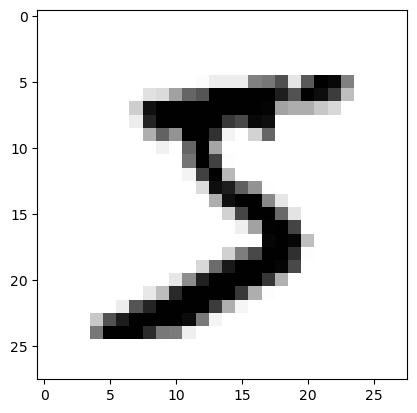

In [4]:
#784개의 특성 : 28*28사이즈의 이미지라서.
import matplotlib.pyplot as plt
def plot_digit(data):
    data = data.reshape(28,28)
    plt.imshow(data,cmap='binary')
plot_digit(X[0])
plt.show()

In [6]:
#항상 데이터 탐색 전에 train test 나눠놓는것을 잊지말자
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

#이진 분류기 훈련
#문제를 단순화해서 5아니면 다른숫자 정도로 나눠보자
y_train_5 = (y_train == '5') #5만 True, 이외 False
y_test_5 = (y_test == '5')

#SGD모델을 사용한다. 이 분류기의 장점은 매우 큰 데이터셋을 효율적으로 처리할 수 있다는 것이다. 
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)


array([False, False, False, ..., False,  True, False])

In [8]:
pred = sgd_clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test_5,pred)

0.9492

In [9]:
#교차검증을 사용한 정확도 측정
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [10]:
#정확도가 매우매우 높게 나온다. 하지만 이는 label이 5와 5가 아닌 것들로 매우 불균형하게 설정되어있기 때문이다. 
#이 예시는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다. 불균형한 데이터셋을 다룰 때, 오차행렬(confusion matrix)를 사용하는 것이 훨씬 좋다.

#우선 validation set을 만들어서 predict값을 생성하자.
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3) #이 함수는 k폴드 교차검증을 수행하고 테스트 폴드에서 얻은 예측을 반환한다.
#즉 validation 정확도라는 소리다.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5,y_pred)
print(cm)

[[53892   687]
 [ 1891  3530]]


In [11]:
#confusion matrix를 살펴보자. 행은 실제 클래스를 나타내고 열은 예측한 클래스를 보여준다. 
#53892개를 5아님으로 정확하게 분류했고, 687개를 5라고 잘못분류했다. 
#두번째 행은 5이미지에 대한 것이고 1891개를 5아님으로 잘못분류했고 3530을 5라고 잘 분류했다.
#완벽하게 분류가 되는 모델이라면 주대각선이 아닌 값들이 0이 나와야한다.

#정밀도 : 양성 예측의 정확도 (진짜 True / 진짜 true + 가짜 true)
#재현율 : 정확하게 감지한 양성 샘플의 비율 (진짜 true / 진짜 true + 거짓 false)
from sklearn.metrics import precision_score,recall_score
print('정밀도',precision_score(y_train_5,y_pred))
print('재현율',recall_score(y_train_5,y_pred))


정밀도 0.8370879772350012
재현율 0.6511713705958311


In [12]:
#정밀도와 재현율을 조화평균하면 f1 score
from sklearn.metrics import f1_score
print('f1 score',f1_score(y_train_5,y_pred))

f1 score 0.7325171197343846


In [13]:
#상황에 따라서 정밀도가 중요할 수 있고, 재현율이 중요할 수 있다.
#예를 들어서 어린아이에게 safe한 동영상을 제공하는 분류기가 있다고 할 때, 재현율이 높은데 가끔 나쁜 동영상이 제공되는 것 보다
#좋은 동영상이 많이 제외되더라도 안전한 동영상을 제공하는 분류기로 만들어야한다. 
#정밀도를 올리면 재현율이 줄고, 재현율을 올리면 정밀도가 줄어든다. 이를 정밀도/재현율 트레이드 오프라고 한다.

#이 트레이드오프 사이에서 최적을 찾아야한다. 이를 scikit learn에서는 predict 대신 decision_funcion()을 호출해서 활인할 수 있다.
#이것을 precision recall curve를 통해서 제공하고 있다. 
from sklearn.metrics import precision_recall_curve
y_score = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

precisions,recalls,thresolds = precision_recall_curve(y_train_5,y_score)

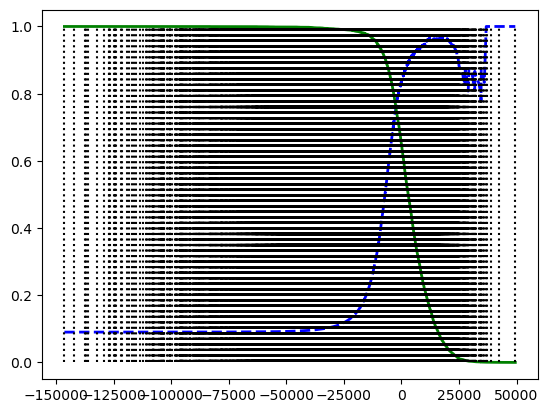

In [16]:
plt.plot(thresolds,precisions[:-1],"b--",label='precisions',linewidth=2)

plt.plot(thresolds,recalls[:-1],"g-",label='recalls',linewidth=2)

plt.vlines(thresolds,0,1.0,'k','dotted',label='thresolds')
plt.show()

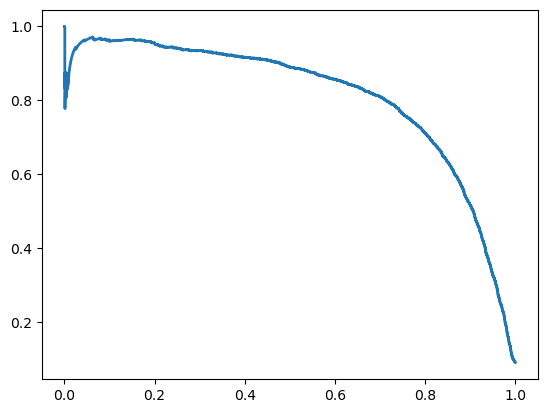

In [17]:
#좋은 정밀도/재현율 트레이드오프를 선택하는 것은 이것과 같이 그리는 방법이다. 
plt.plot(recalls,precisions,linewidth=2,label='precisions/recalls curve')
plt.show()

In [18]:
#재현율 80%근처에서 정밀도가 급격하게 줄어든다. 이 하강점 직전을 트레이드오프로 설정하는 것이 좋다. 
#정밀도 90%를 달성하는 것이 목표라고 할 때 그래프에서 보기만하면 정확한 값을 구할 수 없다.
#따라서 정밀도가 90%가 되는 가장 낮은 임계값을 찾는 것이다.
idx_for_precision = (precisions>=0.90).argmax()
thresolds_for_precision = thresolds[idx_for_precision]
print(thresolds_for_precision)

3370.0194991439557


In [19]:
y_train_pred_90 = (y_score >= thresolds_for_precision)
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [20]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

In [ ]:
#정밀도가 90이상이면서 recall값도 적절하게 나온 것을 확인할 수 있다. 